In [1]:
import skrf
import matplotlib.pyplot as plt
#Use the skrf plot style
skrf.stylely()
%matplotlib inline

![Keysight Pathwave TRL Schematic](trl_calkit.png)

In [2]:
calkit = skrf.Network('calkit.s10p', f_unit='GHz')
calkit = skrf.Network('C:\\Users\\derek\\ADS\\Workspaces\\CreeAsymmetricDoherty_wrk\\data\\calkit.s10p', f_unit='GHz')

print('%i-Port Network: \'%s\',  %s' % (calkit.number_of_ports, calkit.name, str(calkit.frequency)))

10-Port Network: 'calkit',  0.1-24.0 GHz, 240 pts


In [3]:
# Load the uncalibrated S-parameters
trl_thru      = calkit.subnetwork([0,1])
trl_open_s1p  = calkit.subnetwork([2])
trl_match_s1p = calkit.subnetwork([3])
trl_line1     = calkit.subnetwork([4,5])
trl_line2     = calkit.subnetwork([6,7])

# Assemble the two reflection measurements into 2 port networks
trl_open   = skrf.two_port_reflect(trl_open_s1p.s11, trl_open_s1p.s11)
trl_match  = skrf.two_port_reflect(trl_match_s1p.s11, trl_match_s1p.s11)

trl_thru.name = 'thru'
trl_open.name = 'open'
trl_match.name = 'match'
trl_line1.name = '12.34 mm line'
trl_line2.name = '4.79 mm line'

# Load the Beatty DUT
# https://www.signalintegrityjournal.com/articles/194-resonant-test-structures-primer-and-signal-integrity-applications
trl_beatty = calkit.subnetwork([8,9])
trl_beatty.name = 'beatty'

C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)
C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


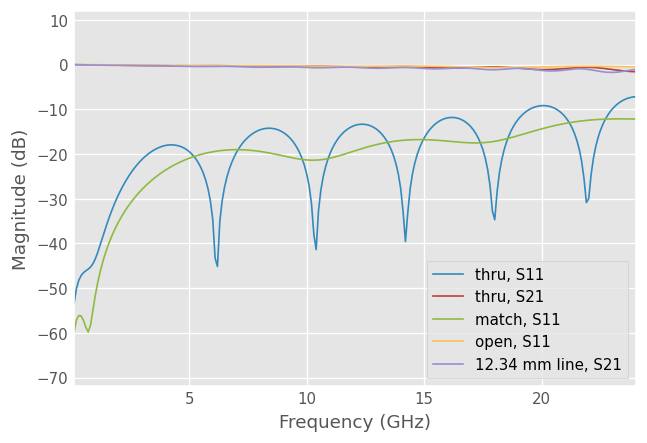

In [4]:
# Print a few representative plots
trl_thru.plot_s_db(0,0)
trl_thru.plot_s_db(1,0)
trl_match.plot_s_db(0,0)
trl_open.plot_s_db(0,0)
trl_line1.plot_s_db(1,0)

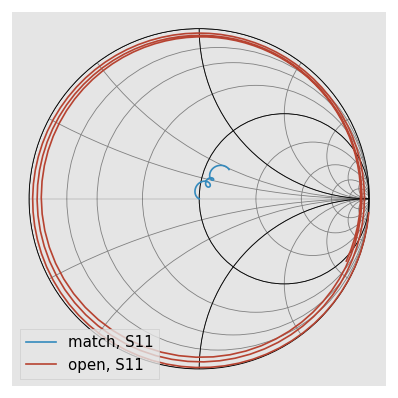

In [5]:
trl_match.plot_s_smith(0,0)
trl_open.plot_s_smith(0,0)

In [6]:
# Simulation is ideal so no switch terms are supplied
#sw_terms = skrf.Network('sw_terms.s2p')
#switch_terms = (sw_terms.s11, sw_terms.s22)

# Measurement with load on both ports for isolation calibration
#ll = skrf.Network('load_load.s2p')

cal_trl = skrf.NISTMultilineTRL(
        measured = [trl_thru, trl_open, trl_line1, trl_line2],
        Grefls = [1], #Estimate of the reflection coefficient
#        er_est = 3.9, #Estimated effective permittivity
        l = [0, 4.79e-3, 12.34e-3], #Line lengths
#        gamma_root_choice = 'real', #Assumes that lines are lossy
#        switch_terms = switch_terms,
#        isolation = ll
        )

C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\calibration\calibration.py:2001: UserWarning: No switch terms provided
  warn('No switch terms provided')


C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)
C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


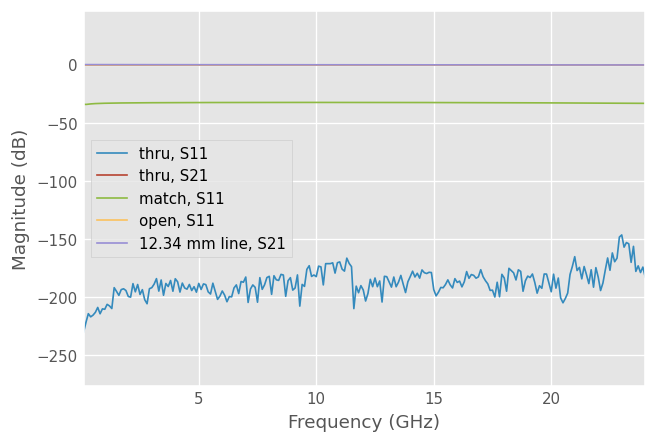

In [7]:
# Print a few representative plots
cal_trl.apply_cal(trl_thru).plot_s_db(0,0)
cal_trl.apply_cal(trl_thru).plot_s_db(1,0)
cal_trl.apply_cal(trl_match).plot_s_db(0,0)
cal_trl.apply_cal(trl_open).plot_s_db(0,0)
cal_trl.apply_cal(trl_line1).plot_s_db(1,0)

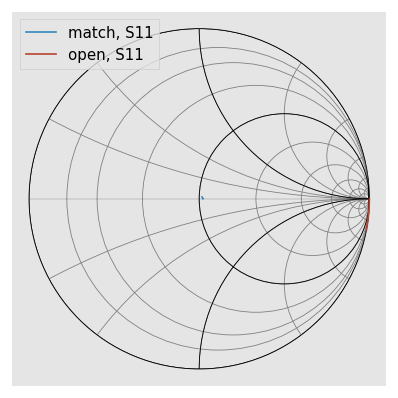

In [8]:
cal_trl.apply_cal(trl_match).plot_s_smith(0,0)
cal_trl.apply_cal(trl_open).plot_s_smith(0,0)

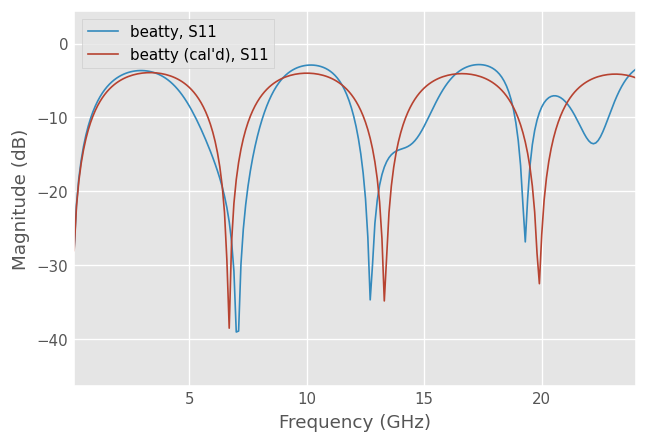

In [9]:
trl_beatty.plot_s_db(0,0)
trl_beatty_corrected = cal_trl.apply_cal(trl_beatty)
trl_beatty_corrected.name = 'beatty (cal\'d)'
trl_beatty_corrected.plot_s_db(0,0)

In [10]:
#cal_trl.plot_errors()

In [11]:
#cal_trl.plot_residuals()

C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\network.py:4007: RuntimeWarning: Frequency doesn't begin from 0. Step response will not be correct.
  warnings.warn(
C:\Users\derek\Miniconda3\envs\phd\lib\site-packages\skrf\network.py:4007: RuntimeWarning: Frequency doesn't begin from 0. Step response will not be correct.
  warnings.warn(


(-0.2, 0.5)

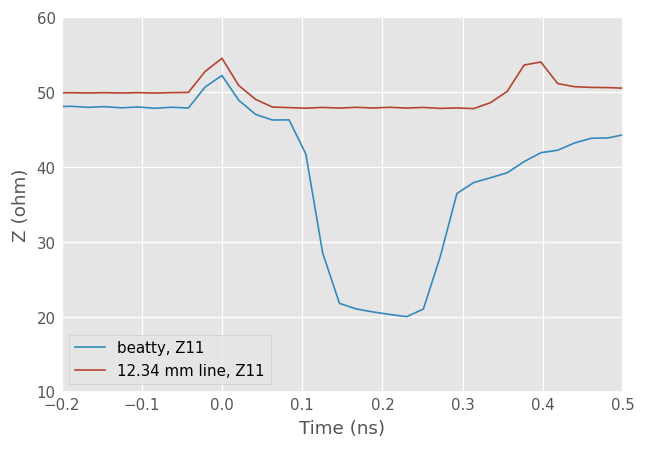

In [12]:
signals = [trl_beatty.s11, trl_line1.s11]

s21 = [s.extrapolate_to_dc(kind='linear') for s in signals]
#s21 = [s.time_gate(center=0, span=.6) for s in signals]
s21 = [s.plot_z_time_step(window='hamming') for s in signals]

plt.ylim((10,60))
plt.xlim((-0.2, 0.5))

In [13]:
from skrf.calibration import (IEEEP370_SE_NZC_2xThru, IEEEP370_MM_NZC_2xThru,
                              IEEEP370_SE_ZC_2xThru, IEEEP370_MM_ZC_2xThru)

In [14]:
dut_dc = dut.extrapolate_to_dc(kind='cubic')
fdf_dc = fdf.extrapolate_to_dc(kind='cubic')
s2xthru_dc = s2xthru.extrapolate_to_dc(kind='cubic')

dm_nzc = IEEEP370_SE_NZC_2xThru(dummy_2xthru = trl_thru, name = '2xthru')
nzc_fix1 = dm_nzc.s_side1
nzc_fix1.name = 'nzc_FIX-1'
nzc_fix2 = dm_nzc.s_side2
nzc_fix2.name = 'nzc_FIX-2'
nzc_d_dut = dm_nzc.deembed(trl_beatty)
nzc_d_dut.name = 'nzc_DUT'
nzc_fix1_dc = nzc_fix1.extrapolate_to_dc(kind='cubic')
nzc_d_dut_dc = nzc_d_dut.extrapolate_to_dc(kind='cubic')

# compute residuals
res_nzc = dm_nzc.deembed(trl_thru)
res_nzc.name = 'nzc_residuals'
res_nzc.s += 1e-15 # avoid numeric singularities

# plot them all
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('Time Step')
dut_dc.s11.plot_z_time_step(window='hamming')
nzc_d_dut_dc.s11.plot_z_time_step(window='hamming')
fdf_dc.s11.plot_z_time_step(window='hamming')
s2xthru_dc.s11.plot_z_time_step(window='hamming')
nzc_fix1_dc.s11.plot_z_time_step(window='hamming')
plt.xlim((-2, 2))
plt.ylim((15, 55))
plt.legend(loc = 'lower left')
plt.subplot(2, 2, 2)
plt.title('Frequency')
dut.plot_s_db(0, 0)
nzc_d_dut.plot_s_db(0, 0)
fdf.plot_s_db(0, 0)
plt.ylim((-40, 5))
plt.subplot(2, 2, 3)
res_nzc.plot_s_db(1,0)
plt.subplot(2, 2, 4)
res_nzc.plot_s_deg(1,0)

NameError: name 'dut' is not defined